# Ordinal Regression

This is the second notebook for a tutorial on "Practical Bayesian Modeling with PyMC"

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/02_categorical_regression.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from utils import value_counts, decorate, load_idata_or_sample

In [4]:
# Make the figures smaller to save some screen real estate

plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Data

The dataset we'll use is an extract from the General Social Survey.
The following cell downloads it.

In [5]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_4.ipynb
# It has been resampled to correct for stratified sampling

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_4.hdf"
download(DATA_PATH + filename)

In [6]:
gss = pd.read_hdf(filename, "gss")
gss.columns

Index(['age', 'attend', 'ballot', 'class', 'clmtcaus', 'clmtusa', 'clmtwrld',
       'cohort', 'commun', 'conarmy', 'conbus', 'conclerg', 'coneduc',
       'confed', 'confinan', 'coninc', 'conjudge', 'conlabor', 'conlegis',
       'conmedic', 'conpress', 'conrinc', 'consci', 'contv', 'degree', 'educ',
       'eqwlth', 'fair', 'fear', 'fund', 'goodlife', 'hapmar', 'happy',
       'health', 'helpful', 'id', 'life', 'partyid', 'polviews', 'pres16',
       'pres20', 'race', 'realinc', 'realrinc', 'reg16', 'region', 'relig',
       'relig16', 'reliten', 'res16', 'rincome', 'satfin', 'satjob', 'sex',
       'sexbirth', 'sexbirth1', 'sexnow', 'sexnow1', 'srcbelt', 'trust',
       'wtssall', 'year'],
      dtype='object')

## Ordinal Regression

In an ordinal regression model, the dependent variable is discrete and ordered.

As an example, we'll consider responses to [this question](https://gssdataexplorer.norc.org/variables/434/vshow):

> Taken all together, how would you say things are these days--would you say that you are very happy, pretty happy, or not too happy?

```
1 Very happy
2 Pretty happy
3 Not too happy
```

This question has been asked almost every year since the first iterations of the survey.

In [7]:
value_counts(gss["happy"])

,counts
values,
1.0,21550
2.0,37446
3.0,8681
NaN,4713


To work with the PyMC implementation of ordinal regression, we need to recode the responses using the values `0`, `1`, and `2`.
While we're at it, we'll reverse the order so higher numbers mean more happy.

In [8]:
gss["y"] = gss["happy"].replace([1, 2, 3], [2, 1, 0])
value_counts(gss["y"], normalize=True) * 100

,proportion
values,
0.0,11.991988
1.0,51.728139
2.0,29.769305
NaN,6.510568


And we'll use this dictionary to map from codes to strings.

In [9]:
happy_map = {
    2: "Very happy",
    1: "Pretty happy",
    0: "Not too happy",
}

In the regression model, we'll use respondents' ages as a predictor.
But first we'll visualize the relationship by making 5-year age groups.

In [10]:
from utils import round_into_bins

gss["age_group"] = round_into_bins(gss["age"], 5, low=13) + 2

And computing the proportion of responses in each group.

In [11]:
age_table = (
    pd.crosstab(gss["age_group"], gss["y"], normalize="index").rename(columns=happy_map)
    * 100
)
age_table

y,Not too happy,Pretty happy,Very happy
age_group,,,
20.0,14.754098,60.232681,25.013221
25.0,13.913290,57.778407,28.308303
30.0,11.215502,57.706988,31.077510
35.0,11.491515,55.894611,32.613873
40.0,12.492298,55.653112,31.854590
45.0,12.417871,56.964520,30.617608
50.0,12.726350,54.543916,32.729734
55.0,14.437804,53.119163,32.443033
60.0,12.406736,54.103603,33.489661


Here are the results.

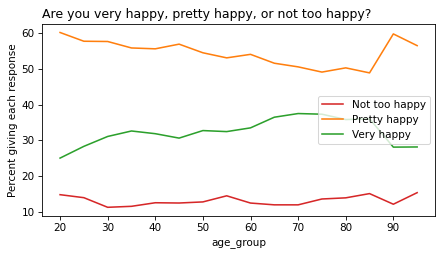

In [12]:
colors = ["C3", "C1", "C2"]
age_table.plot(color=colors)

ylabel = "Percent giving each response"
title = "Are you very happy, pretty happy, or not too happy?"
decorate(ylabel=ylabel, title=title)

It looks like older people are more likely to say "very happy" and less likely to say "pretty happy".

It is tempting to conclude that people get happier as they get older, but with this figure alone, we can't tell whether these trends are an age effect or a cohort effect.

We can get a clearer picture by looking at birth years.
As we did with age, we'll group people into 5-year birth cohorts.

In [13]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)

In [14]:
gss["birth_group"] = round_into_bins(gss["cohort"], 5, low=1903) + 2
gss.groupby("birth_group")["cohort"].describe()

,count,mean,std,min,25%,50%,75%,max
birth_group,,,,,,,,
1905.0,830.0,1905.213253,1.430857,1903.0,1904.0,1905.0,1907.0,1907.0
1910.0,1275.0,1910.114510,1.452892,1908.0,1909.0,1910.0,1911.5,1912.0
1915.0,1909.0,1915.102148,1.422174,1913.0,1914.0,1915.0,1916.0,1917.0
1920.0,2522.0,1920.087629,1.429506,1918.0,1919.0,1920.0,1921.0,1922.0
1925.0,3102.0,1925.071889,1.431998,1923.0,1924.0,1925.0,1926.0,1927.0
1930.0,3102.0,1930.059961,1.403783,1928.0,1929.0,1930.0,1931.0,1932.0
1935.0,3566.0,1935.065059,1.375492,1933.0,1934.0,1935.0,1936.0,1937.0
1940.0,4343.0,1940.103155,1.433124,1938.0,1939.0,1940.0,1941.0,1942.0
1945.0,5656.0,1945.124470,1.449801,1943.0,1944.0,1945.0,1946.0,1947.0


In [15]:
cohort_table = (
    pd.crosstab(gss["birth_group"], gss["y"], normalize="index").rename(
        columns=happy_map
    )
    * 100
)

Here is the distribution of responses as a function of year of birth.

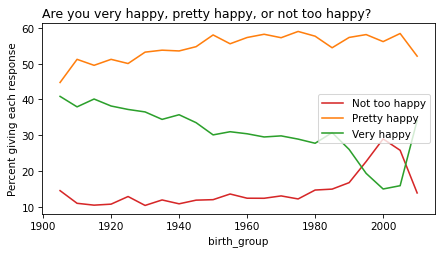

In [16]:
cohort_table.plot(color=colors)
decorate(ylabel=ylabel, title=title)

It looks like people born later are less likely to say "very happy".

Now that we've explored the data, let's make a model.

## Ordinal Regression

For the first model, we'll use age as the predictor.
So we'll drop rows that are missing responses to `happy` or `age`.

In [17]:
data = gss.dropna(subset=["y", "age"])
data.shape

(66959, 65)

Because this dataset is large, the sampler takes a while to run.
While debugging, it is often useful to work with a random subset of the data.

In [18]:
# data = data.sample(5000)

To prepare the data for the model, we'll make NumPy arrays and center age.

In [19]:
y = data["y"].to_numpy()
age = data["age"].to_numpy()

# Center age
age_shift = age.mean()
age_centered = age - age_shift

Now let's talk about the idea behind ordinal regression.

Like previous models, it's based on the assumption that each person has a latent propensity to give answers at a particular point on a scale, and that this propensity determines their probability of giving each response.
As in the previous models, these propensities are represented on a log-odds scale.

What's new in ordinal regression is the additional assumption that there are "cutpoints" at unknown locations on the scale that divide the scale into segments.
If someone's propensity is less than the lowest cutpoint, they are most likely to give the lowest response.
If their propensity exceeds the highest cutpoint, they are most likely to give the highest response.

Specifically, here's how we compute the probability of each response.

First, we compute a latent value for each person based on their age:

$$
\eta_i = \beta_{\text{age}} \cdot \text{age}_{i}
$$

Next, we compute the **cumulative probabilities** using the cutpoints:

- Probability of responding in category 0 or lower:

$$
P(y_i \leq 0) = \text{expit}(c_1 - \eta_i)
$$

- Probability of responding in category 1 or lower:

$$
P(y_i \leq 1) = \text{expit}(c_2 - \eta_i)
$$

Then we subtract to get the **marginal probabilities** for each response category:

- Probability of response = 0:

$$
P(y_i = 0) = P(y_i \leq 0)
$$

- Probability of response = 1:

$$
P(y_i = 1) = P(y_i \leq 1) - P(y_i \leq 0)
$$

- Probability of response = 2:

$$
P(y_i = 2) = 1 - P(y_i \leq 1)
$$


When we sample the model, it estimates the cutpoints and the coefficient of age simultaneously.
But we can get a general idea of where the cutpoints are by computing the proportions in each category on a log-odds scale.

In [20]:
from scipy.special import logit

cutpoint_0 = logit(0.12)  # Cutpoint between "Not too happy" and "Pretty happy"
cutpoint_1 = logit(0.64)  # Cutpoint between "Pretty happy" and "Very happy"

print(cutpoint_0, cutpoint_1)

-1.9924301646902063 0.5753641449035619


We can use this peek at the data to choose a prior for the cutpoints.
This helps the sampler get started -- other than that, it doesn't affect the results much.

Here's the DIY implementation of the model.

In [21]:
with pm.Model() as ordinal_model_diy:
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal(
        "cutpoints",
        mu=np.array([-2, 0.6]),
        sigma=0.5,
        shape=2,
        transform=pm.distributions.transforms.ordered,
    )

    # Age slope
    beta_age = pm.Normal("beta_age", 0, 0.1)

    # Linear predictor for each respondent (this is just age effect)
    eta = beta_age * age_centered  # shape (n,)

    # Compute cumulative logits for each observation and each cutpoint
    logits = cutpoints - eta[:, None]  # shape (n, 2)

    # Convert logits to cumulative probabilities
    cdf_0 = pm.math.sigmoid(logits[:, 0])  # P(y ≤ 0)
    cdf_1 = pm.math.sigmoid(logits[:, 1])  # P(y ≤ 1)

    # Convert cumulative probabilities to category probabilities
    p0 = cdf_0
    p1 = cdf_1 - cdf_0
    p2 = 1 - cdf_1

    # Stack into final probability matrix
    p = pm.math.stack([p0, p1, p2], axis=1)

    # Likelihood using explicit p
    y_obs = pm.Categorical("y_obs", p=p, observed=y)

The transform sorts the cutpoints so they are in order -- otherwise the cumulative probabilities would not be ordered and their differences could be negative.

Here's an equivalent model using the built-in `OrderedLogistic` function.

In [22]:
with pm.Model() as ordinal_model:
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal(
        "cutpoints",
        mu=np.array([-2, 0.6]),
        sigma=0.5,
        shape=2,
        transform=pm.distributions.transforms.ordered,
    )

    # Age slope
    beta_age = pm.Normal("beta_age", 0, 0.1)

    # Compute cumulative logits
    eta = beta_age * age_centered

    # Hide the details of the calculation
    y_obs = pm.OrderedLogistic(
        "y_obs", eta=eta, cutpoints=cutpoints, compute_p=False, observed=y
    )

Here's what it looks like.

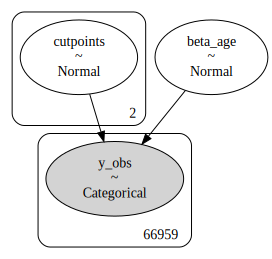

In [23]:
pm.model_to_graphviz(ordinal_model)

Now let's run the sampler.

In [24]:
filename = 'ordinal_model_idata.nc'
idata = load_idata_or_sample(ordinal_model_diy, filename, draws=500, tune=500)

Loaded idata from ordinal_model_idata.nc


The posterior distribution of the cutpoints is consistent with our estimates based on the data.

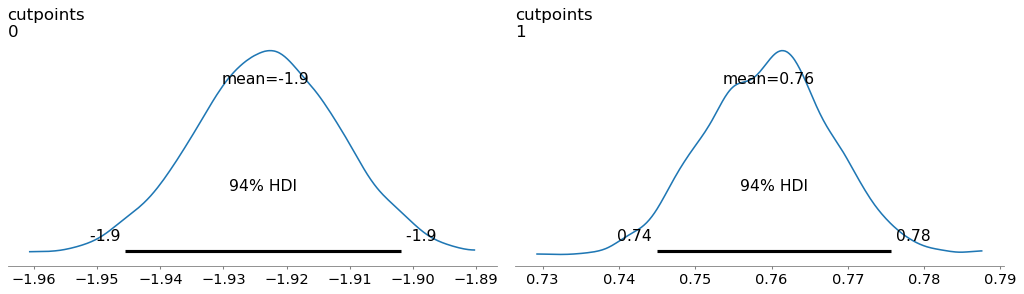

In [25]:
az.plot_posterior(idata, var_names=["cutpoints"])
decorate()

And here's the coefficient of age.

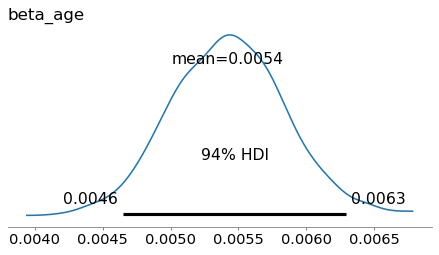

In [26]:
az.plot_posterior(idata, var_names=["beta_age"])
decorate()

The traces look good.

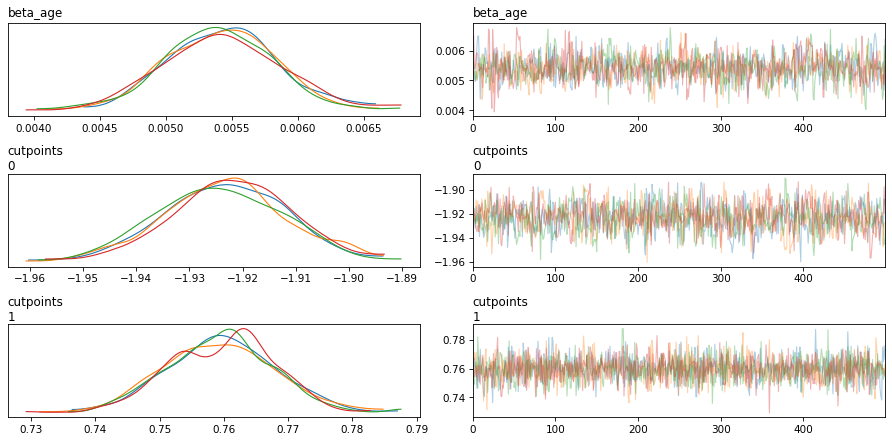

In [27]:
az.plot_trace(idata, compact=False)
decorate()

And the diagnostics are  good.

In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_age,0.005,0.000,0.005,0.006,0.0,0.0,1306.0,1146.0,1.0
cutpoints[0],-1.923,0.012,-1.946,-1.902,0.0,0.0,1080.0,1041.0,1.0
cutpoints[1],0.760,0.008,0.745,0.776,0.0,0.0,2954.0,1789.0,1.0


## Interpreting the results

We'll generate predictions over a range of ages.

In [29]:
# Center the age range
age_range = np.arange(18, 95)
age_range_centered = age_range - age_shift
n_ages = len(age_range)

In [30]:
n_samples = 100
samples = az.extract(idata, num_samples=n_samples)

cutpoints = samples["cutpoints"].to_numpy()
cutpoints.shape

(2, 100)

In [31]:
beta_age = samples["beta_age"].to_numpy()
beta_age.shape

(100,)

For each set of cutpoints and age coefficient, we compute the probabilities for each of the three categories over a range of ages.

In [32]:
from scipy.special import expit

# Predicted probabilities: shape (n_samples, n_ages, 3)
predicted_probs = np.zeros((n_samples, n_ages, 3))

for i in range(n_samples):
    cp0, cp1 = cutpoints[:, i]
    slope = beta_age[i]

    eta = np.array([cp0, cp1]) - slope * age_range_centered[:, None]

    # Convert to cumulative probabilities
    cdf_0 = expit(eta[:, 0])
    cdf_1 = expit(eta[:, 1])

    # Convert to category probabilities
    p0 = cdf_0
    p1 = cdf_1 - cdf_0
    p2 = 1 - cdf_1

    predicted_probs[i] = np.stack([p0, p1, p2], axis=1) * 100

Here's what the results look like.

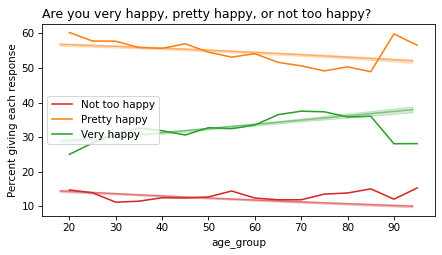

In [33]:
age_table.plot(color=colors)

for k, name in happy_map.items():
    mean_prob = predicted_probs[:, :, k].mean(axis=0)
    hdi_low, hdi_high = np.percentile(predicted_probs[:, :, k], [5, 95], axis=0)

    plt.plot(age_range, mean_prob, color=colors[k], alpha=0.5)
    plt.fill_between(age_range, hdi_low, hdi_high, color=colors[k], alpha=0.2)

decorate(ylabel=ylabel, title=title)

It looks like the model does a pretty good job capturing the trends in the data.

## Adding a second predictor

To estimate the effect of age and cohort separately, we'll add birth year as a second predictor.

In [34]:
data = gss.dropna(subset=["y", "age", "cohort"])
data.shape

(66958, 65)

Again, you might want to run with a subset of the data so the sampler runs faster.

In [35]:
# data = data.sample(5000)

Again, we'll prepare the data and center both predictors.

In [36]:
y = data["y"].to_numpy()
age = data["age"].to_numpy()
cohort = data["cohort"].to_numpy()

In [37]:
# Center age
age_shift = age.mean()
age_centered = age - age_shift

In [38]:
# Center cohort
cohort_shift = cohort.mean()
cohort_centered = cohort - cohort_shift

Here's the model with the added predictor.

In [39]:
with pm.Model() as ordinal_model2:
    # Priors for cutpoints (thresholds)
    cutpoints = pm.Normal(
        "cutpoints",
        mu=np.array([-2, 0.6]),
        sigma=0.5,
        shape=2,
        transform=pm.distributions.transforms.ordered,
    )

    # Slopes for age and cohort
    beta_age = pm.Normal("beta_age", 0, 0.1)
    beta_cohort = pm.Normal("beta_cohort", 0, 0.1)

    # Linear predictor (age effect + cohort effect)
    eta = beta_age * age_centered + beta_cohort * cohort_centered

    # Ordinal likelihood
    y_obs = pm.OrderedLogistic(
        "y_obs", eta=eta, cutpoints=cutpoints, compute_p=False, observed=y
    )

Here's what it looks like.

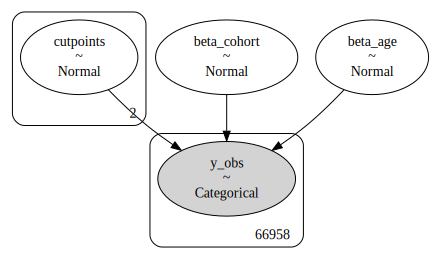

In [40]:
pm.model_to_graphviz(ordinal_model2)

Run that sampler...

In [41]:
filename = 'ordinal_model2_idata.nc'
idata2 = load_idata_or_sample(ordinal_model2, filename, draws=500, tune=500)

Loaded idata from ordinal_model2_idata.nc


The traces and diagnostics look good.

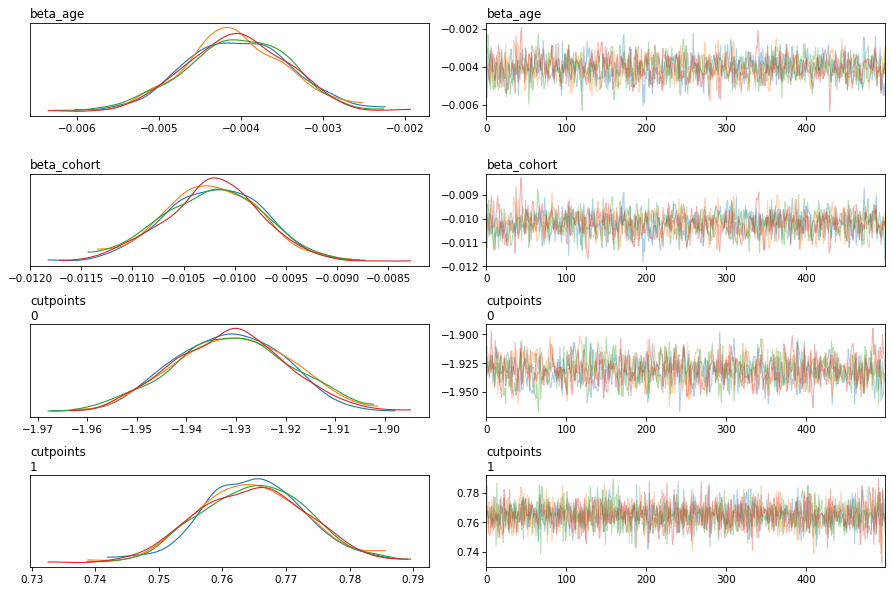

In [42]:
az.plot_trace(idata2, compact=False)
decorate()

In [43]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_age,-0.004,0.001,-0.005,-0.003,0.0,0.0,1194.0,1269.0,1.00
beta_cohort,-0.010,0.000,-0.011,-0.009,0.0,0.0,1115.0,1306.0,1.00
cutpoints[0],-1.931,0.011,-1.953,-1.911,0.0,0.0,958.0,1289.0,1.00
cutpoints[1],0.765,0.008,0.749,0.781,0.0,0.0,2889.0,1712.0,1.01


The posterior distribution of the cutpoints is not much different.

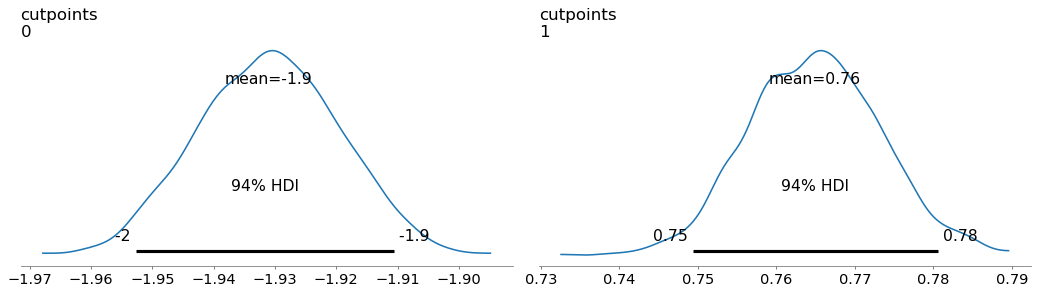

In [44]:
az.plot_posterior(idata2, var_names=['cutpoints'])
decorate()

The posterior distributions for both coefficients are negative, which suggests that the age effect and cohort effect point in the same direction: people get less happy with age (during this period) and successive cohorts are less happy.

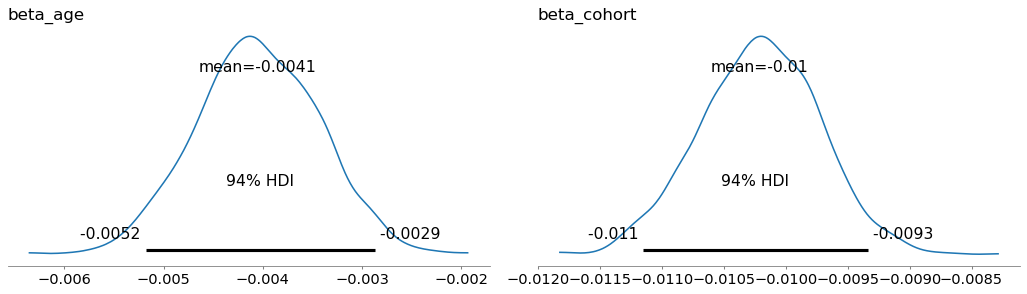

In [45]:
az.plot_posterior(idata2, var_names=['beta_age', 'beta_cohort'])
decorate()

And the cohort effect appears to be about two times bigger.

## Plotting the results

Since we have two predictors, we'll visualize the results two ways: varying age while holding birth year constant, and the other way around.

In [46]:
data["age"].mean()

44.982750380835746

In [47]:
data["cohort"].mean()

1952.1698527435108

We'll extract a sample from the posterior distribution as we've done before.

In [48]:
n_samples = 100
samples = az.extract(idata2, num_samples=n_samples)

cutpoints = samples["cutpoints"].to_numpy()
cutpoints.shape

(2, 100)

In [49]:
beta_age = samples["beta_age"].to_numpy()
beta_age.shape

(100,)

In [50]:
beta_cohort = samples["beta_cohort"].to_numpy()
beta_cohort.shape

(100,)

It is a little more complicated now to compute the predicted probabilities.
The following function encapsulates the logic.

In [51]:
def compute_predicted_probs(cutpoints, beta_age, beta_cohort, age_centered, cohort_centered):
    """Compute predicted probabilities for each age/cohort combination.

    cutpoints: array of shape (2, n_samples)
    beta_age: array of shape (n_samples,)
    beta_cohort: array of shape (n_samples,)
    age_centered: array of shape (n_ages,)
    cohort_centered: array of shape (n_cohorts,)

    Returns: array of shape (n_samples, n_ages, n_cohorts, 3)
    """
    n_samples = beta_age.shape[0]
    n_ages = len(age_centered)
    n_cohorts = len(cohort_centered)

    # Broadcast to shape (n_samples, n_ages, n_cohorts)
    eta = (beta_age[:, None, None] * age_centered[None, :, None] +
           beta_cohort[:, None, None] * cohort_centered[None, None, :])

    # Broadcast cutpoints to match shape
    cut_0 = cutpoints[0][:, None, None]
    cut_1 = cutpoints[1][:, None, None]

    # Compute cumulative logits
    cdf_0 = expit(cut_0 - eta)
    cdf_1 = expit(cut_1 - eta)

    # Compute category probabilities
    p0 = cdf_0
    p1 = cdf_1 - cdf_0
    p2 = 1 - cdf_1

    # Stack along last axis and scale to percentages
    predicted_probs = np.stack([p0, p1, p2], axis=-1) * 100

    return predicted_probs

First we'll compute probabilities for a range of ages with cohort fixed.

In [52]:
# Center the age range
age_range = np.arange(18, 95)
age_centered = age_range - age_shift

# Fixed cohort value
cohort_fixed = np.array([1960])
cohort_centered = cohort_fixed - cohort_shift

predicted_probs = compute_predicted_probs(
    cutpoints, beta_age, beta_cohort, age_centered, cohort_centered
)

Here's what it looks like.

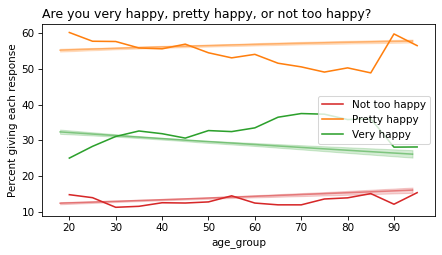

In [53]:
age_table.plot(color=colors)

for k in range(3):
    prob = predicted_probs[:, :, 0, k]
    mean_prob = prob.mean(axis=0)
    hdi_low, hdi_high = np.percentile(prob, [5, 95], axis=0)

    plt.plot(age_range, mean_prob, color=colors[k], alpha=0.5)
    plt.fill_between(age_range, hdi_low, hdi_high, color=colors[k], alpha=0.2)

decorate(ylabel=ylabel, title=title)

We don't expect the results to match the data perfectly, because the predictions are for a specific birth year and the data contain a mixture of birth years.

Here are the probabilities for a range of birth years -- with a little bit of extrapolation -- with age fixed.

In [54]:
# Center the cohort range
cohort_range = np.arange(1905, 2020)
cohort_centered = cohort_range - cohort_shift

# Fixed age
age_fixed = np.array([40])
age_centered = age_fixed - age_shift

predicted_probs = compute_predicted_probs(
    cutpoints, beta_age, beta_cohort, age_centered, cohort_centered
)

And here's what the results look like.

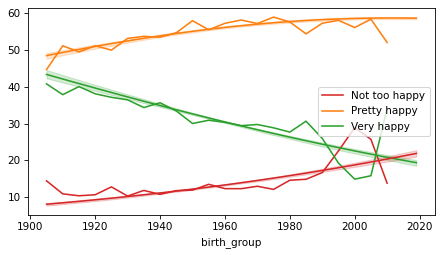

In [55]:
cohort_table.plot(color=colors)

for k, name in happy_map.items():
    prob = predicted_probs[:, 0, :, k]
    mean_prob = prob.mean(axis=0)
    hdi_low, hdi_high = np.percentile(prob, [5, 95], axis=0)

    plt.plot(cohort_range, mean_prob, color=colors[k])
    plt.fill_between(cohort_range, hdi_low, hdi_high, color=colors[k], alpha=0.2)

decorate()

One use of a model like this is to generate projections and counterfactuals.

As a next step, we could consider adding predictors like gender, marital status, education, and income.